In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model, Sequential
from tensorflow.keras.layers import *
from keras.src.backend import Variable
import tensorflow as tf

2024-04-07 14:45:36.653482: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-07 14:45:37.096416: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-07 14:45:38.013479: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Load MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize data and flatten images
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((-1, 784))
x_test = x_test.reshape((-1, 784))

# Verification subset
X_subset = x_train[:1000]
y_subset = y_train[:1000]



In [3]:
X_ordered = X_subset[np.argsort(y_subset)]
y_ordered = y_subset[np.argsort(y_subset)]

<Axes: >

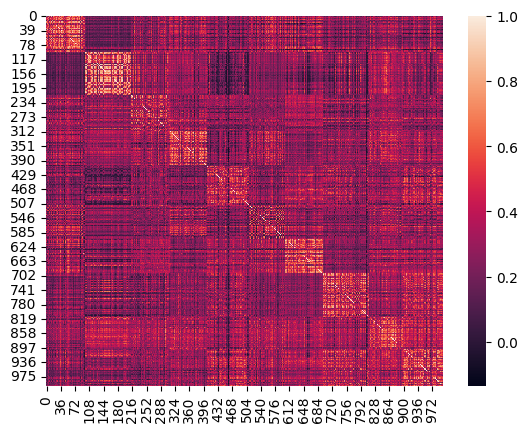

In [4]:
import seaborn as sns

sns.heatmap(np.corrcoef(X_ordered))

In [5]:
def euclid_distances_tf(X):
    sum_square = tf.reduce_sum(tf.square(X), axis=1)
    distances = tf.sqrt(sum_square[:, tf.newaxis] + sum_square - 2 * tf.matmul(X, X, transpose_b=True)+1e-4)
    return distances



In [6]:

distances = euclid_distances_tf(X_ordered)


2024-04-07 14:45:42.303330: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-07 14:45:42.303884: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


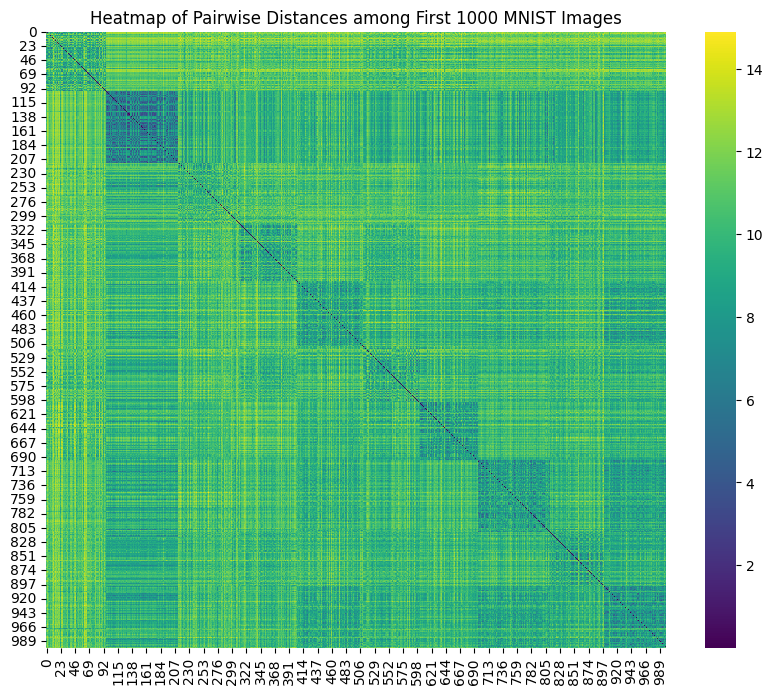

In [7]:

# Plot heatmap of the pairwise distances matrix
plt.figure(figsize=(10, 8))
sns.heatmap(distances, cmap='viridis')
plt.title('Heatmap of Pairwise Distances among First 1000 MNIST Images')
plt.show()

# domowe tSNE

In [48]:
# def correlation(matrix):
#     # same as numpy.corrcoef but for tensorflow
#     means = tf.reduce_mean(matrix, axis=1, keepdims=True)
#     diff = matrix - means
#     dot_products = tf.matmul(diff, diff, transpose_b=True)
#     norms = tf.norm(diff, axis=1, keepdims=True)
#     return dot_products / tf.matmul(norms, norms, transpose_b=True)

# def correlation_loss(X, Y):
#     return tf.reduce_mean((correlation(X) - correlation(Y))**2)

In [49]:


# Define a custom loss function based on Euclidean distances
def euclid_loss_tf(y_true, y_pred):
    return tf.reduce_mean((euclid_distances_tf(y_true) - euclid_distances_tf(y_pred))**2)

In [38]:
from tensorflow.keras.layers import *

In [50]:
latent_dim = 20
model = Sequential([
    Input(shape=(784,)),
    Reshape((28, 28, 1)),
    Conv2D(32, kernel_size=(3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(latent_dim, activation="relu"),
])

model.compile(optimizer="adam", loss=euclid_loss_tf)
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_7 (Reshape)             │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 20)             │        32,020 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,836 (198.58 KB)

 Trainable params: 50,836 (198.58 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
type(X_ordered)

numpy.ndarray

In [52]:
history = model.fit(X_ordered, X_ordered, epochs=100, batch_size=256, shuffle=True, validation_data=(X_ordered, X_ordered))

Epoch 1/100


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 91.6744 - val_loss: 83.1734
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 71.7180 - val_loss: 62.6556
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 51.8921 - val_loss: 97.3846
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 102.6769 - val_loss: 97.3846
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 102.1994 - val_loss: 97.3846
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 102.6617 - val_loss: 97.3846
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 103.0903 - val_loss: 97.3846
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 102.3199 - val_loss: 97.3846
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 102.7376 - val_loss: 97.3846
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 102.3820 - val_loss: 97.3846
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 102.6822 - val_loss: 97.3846
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - los

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
(1000, 20)


<Axes: >

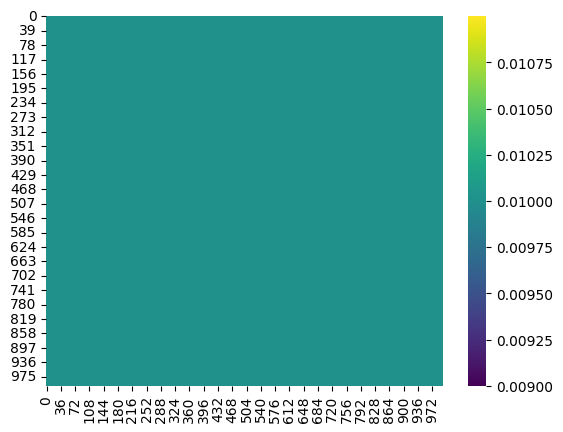

In [53]:
embeddings = model.predict(X_ordered)
print(embeddings.shape)
sns.heatmap(euclid_distances_tf(embeddings), cmap='viridis')



In [15]:
model.predict(X_ordered).shape

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


(1000, 20)

# domowe tSNE w akcji

In [39]:
x_train.shape

(60000, 784)

In [40]:
X_1 = x_train[y_train == 1]
y_1 = y_train[y_train == 1]

In [42]:
latent_dim = 2
model = Sequential([
    Input(shape=(784,)),
    Reshape((28, 28, 1)),
    Conv2D(32, kernel_size=(3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dropout(0.0),
    Dense(44, activation="relu"),
    Dense(latent_dim, activation="relu"),
])

model.compile(optimizer="adam", loss=euclid_loss_tf)
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_6 (Reshape)             │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 44)             │        70,444 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │            90 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,350 (349.02 KB)

 Trainable params: 89,350 (349.02 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
history = model.fit(X_1, X_1, epochs=10, batch_size=256, shuffle=True, validation_data=(X_1, X_1))

Epoch 1/10


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 31.3493 - val_loss: 8.7832
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 7.6173 - val_loss: 6.3158
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 6.2271 - val_loss: 44.1590
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 44.8216 - val_loss: 44.1590
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 44.7883 - val_loss: 44.1590
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 44.5503 - val_loss: 44.1590
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 44.9198 - val_loss: 44.1590
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 44.8095 - val_loss: 44.1590
Epoch 9/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 44.6026 - val_loss: 44.1590
Epoch 10/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 44.7207 - val_loss: 44.1590


In [47]:
X_tsne = model.predict(X_1)
X_tsne

211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)

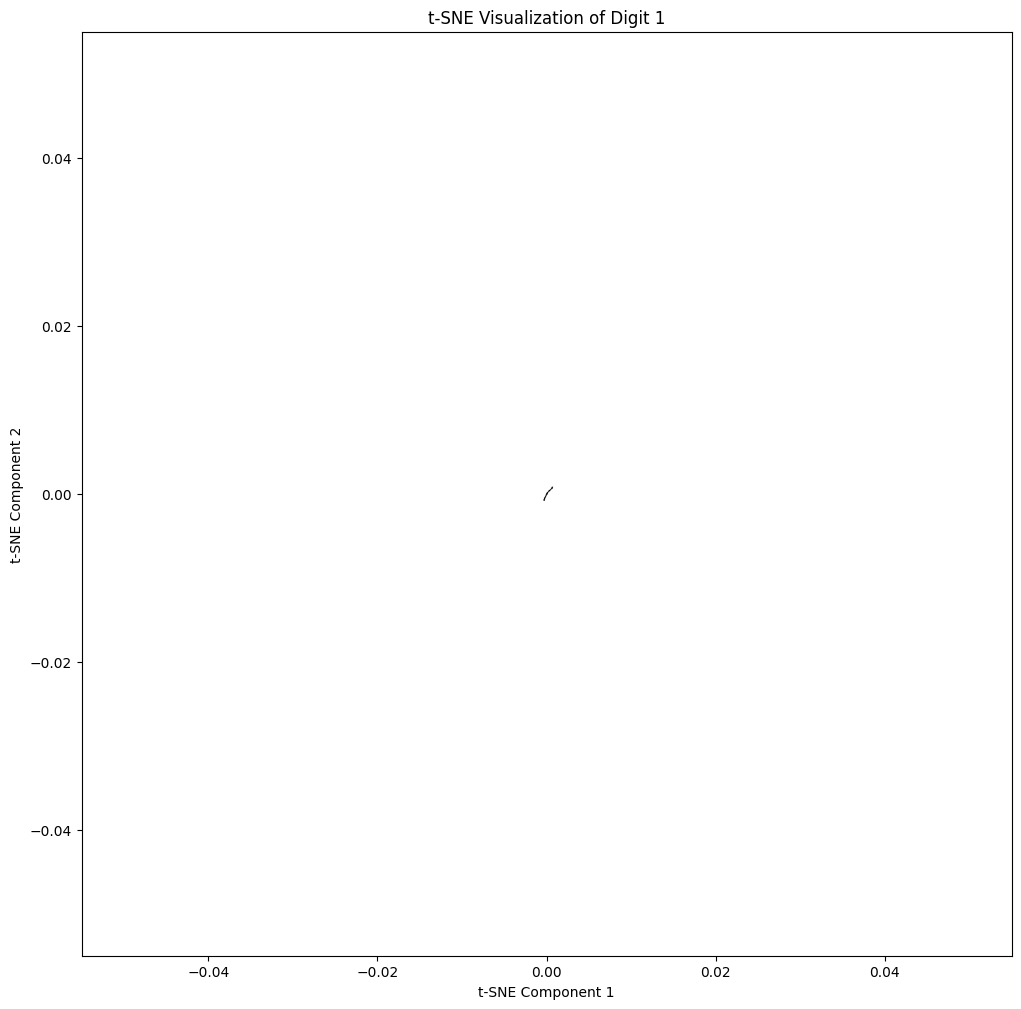

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn import datasets
from sklearn.manifold import TSNE


# Step 5: Scatterplot with digit markers
fig, ax = plt.subplots(figsize=(12, 12))
scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1])

# Annotate a few points with their digit images
for i in range(0, X_1.shape[0], 1):  # Adjust the step for more/less images
    digit_image = X_1[i].reshape(28, 28)
    imagebox = OffsetImage(digit_image, zoom=0.5, cmap='binary')
    ab = AnnotationBbox(imagebox, (X_tsne[i, 0], X_tsne[i, 1]), frameon=False)
    ax.add_artist(ab)

ax.set_title('t-SNE Visualization of Digit 1')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')

plt.show()